<a href="https://colab.research.google.com/github/pb111/Data-Science-Portfolio-in-Python/blob/master/Stacked_Classifier_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stacked Classifier Project** 


This notebook gives a very simple and basic introduction to an ensemble learning technique known as **stacking**. The objective of this notebook is to provide an intuitive understanding and implement **stacking**. We have used the famous titanic dataset for the illustration purposes.


Now let's begin our journey to understand stacking. So, let's dive in.

# **Table of Contents**

- 1.	Introduction to Stacking
- 2.	Stacking is prone to overfitting
- 3.	Basic set-up
      - 3.1	Import libraries
      - 3.2	Load data
- 4.	Data exploration
      - 4.1	Shape of the datasets
      - 4.2	Preview datasets
      - 4.3	Summary of datasets
      - 4.4	Check for missing values
      - 4.5	Statistical properties of dataset
      - 4.6	Types of variables
- 5.	Data Visualization
      - 5.1	Missing values
      - 5.2	Explore passenger variables
          - 5.2.1	Survived
          - 5.2.2	Sex
          - 5.2.3	Pclass
          - 5.2.4	Embarked
          - 5.2.5	Age
      - 5.3	Visualizations about training set
      - 5.4	Correlation heatmap
- 6.	Data Preprocessing
      - 6.1	Missing values imputation
- 7.	Feature Engineering
- 8.	Categorical Encoding
- 9.	Feature Scaling
- 10.	Declare feature vector and target label
- 11.	Individual Classifiers
- 12.	Stacked Classifier







## **1. Introduction to Stacking** 


- [Stacking](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/) is an ensemble machine learning technique to combine multiple individual classification models via a meta-classifier. 

- But, wait what is a meta-classifier?

- Let's visualize the schematic representation of meta classifier below.


![Stacked Classifier](https://www.researchgate.net/profile/David_Powers2/publication/264125265/figure/fig1/AS:295914087436290@1447562824204/Fusion-system-based-on-stacking.png)

From the above diagram, we can conclude that stacking can be thought of as a two step process -

##### **Step 1** : In the first step, the individual classification models are trained based on the complete training set and their individual outputs are stored. These individual classification models are referred to as **Level One or Base Classifiers**.


##### **Step 2** : In the second step, the predictions of individual classifiers (referred to as **Level One or Base Classifiers**) are used as new features to train a new classifier. This new classifier is called **Meta Classifier**. The meta-classifier can be any classifier of our choice. 


The meta-classifier is fitted based on the outputs -- **meta-features** -- of the individual classification models in the ensemble. The meta-classifier can either be trained on the predicted class labels or probabilities from the ensemble.

The figure below shows how three different classifiers get trained. Their predictions get stacked and are used as features to train the meta-classifier which makes the final prediction.

![Stacked Classifier](https://miro.medium.com/max/2044/1*5O5_Men2op_sZsK6TTjD9g.png)

## **2. Stacking is prone to overfitting** 


- This type of Stacking is prone to overfitting due to information leakage.

- To prevent information leakage into the training set from the target set, the level one predictions should come from a subset of the training data that was not used to train the level one classifiers.

- This can be applied by applying k-fold cross validation technique. In this technique, the training data is split into k-folds. Then the first k-1 folds are used to train the level one classifiers. The validation fold is then used to generate a subset of the level one predictions. The process is repeated for each unique group to generate the level one predictions.

- The figure below illustrates this process -

![k-fold Cross Validation Techniques](https://miro.medium.com/max/2972/1*RP0pkQEOSrw9_EjFu4w3gg.png)

- Now, let's get to implementation of stacking or stacked classifier.

- The first step is to import the libraries and dataset

## **3. Basic set-up** 



### **3.1 Import libraries** 

In [1]:
## Ignore warning
import warnings 
warnings.filterwarnings('ignore') 


# Data processing and analysis libraries
import numpy as np
import pandas as pd
import re


# Data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


# Configure visualisations
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)


# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier


# Data preprocessing :
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder


# Modeling helper functions
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score


# Classification metrices
from sklearn.metrics import accuracy_score

### **3.2 Load data** 



In [2]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# Load train and Test set

%time

train_df = pd.read_csv('/content/drive/MyDrive/datasets/Stacking/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/datasets/Stacking/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/datasets/Stacking/gender_submission.csv')
IDtest = test_df['PassengerId']

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


## **4. Data exploration** 


### **4.1 Shape of the datasets**

In [6]:
print(f'The shape of the training set : ', (train_df.shape))
print(f'The shape of the test set : ', (test_df.shape))
print(f'The shape of the submission set : ', (submission_df.shape))

The shape of the training set :  (891, 12)
The shape of the test set :  (418, 11)
The shape of the submission set :  (418, 2)


### **4.2 Preview datasets**

In [7]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### **4.3 Summary of datasets**

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We suspect missing values in `Age`,`Cabin` and `Embarked` in training set. We will explore it later.

In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Here, missing values occur in `Age`,`Fare` and `Cabin`. We will see it later.

### **4.4 Check for missing values**

In [11]:
# missing values in training set

var1 = [col for col in train_df.columns if train_df[col].isnull().sum() != 0]

print(train_df[var1].isnull().sum())

Age         177
Cabin       687
Embarked      2
dtype: int64


So, we are right that `Age`, `Cabin` and `Embarked` contain missing values in training set.

In [12]:
# missing values in test set

var2 = [col for col in test_df.columns if test_df[col].isnull().sum() != 0]

print(test_df[var2].isnull().sum())

Age       86
Fare       1
Cabin    327
dtype: int64


`Age`, `Fare` and `Cabin` contain missing values in test set.

### **4.5 Statistical properties of dataset**

In [13]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [14]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### **4.6 Types of variables**


Now, we will classify the variables into categorical and numerical variables.

In [15]:
# find categorical variables in training set

categorical1 = [var for var in train_df.columns if train_df[var].dtype =='O']

print('There are {} categorical variables in training set.\n'.format(len(categorical1)))

print('The categorical variables are :', categorical1)

There are 5 categorical variables in training set.

The categorical variables are : ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [16]:
# find numerical variables in training set

numerical1 = [var for var in train_df.columns if train_df[var].dtype !='O']

print('There are {} numerical variables in training set.\n'.format(len(numerical1)))

print('The numerical variables are :', numerical1)

There are 7 numerical variables in training set.

The numerical variables are : ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [17]:
# find categorical variables in test set

categorical2 = [var for var in test_df.columns if test_df[var].dtype =='O']

print('There are {} categorical variables in test set.\n'.format(len(categorical2)))

print('The categorical variables are :', categorical2)

There are 5 categorical variables in test set.

The categorical variables are : ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [18]:
# find numerical variables in test set

numerical2 = [var for var in test_df.columns if test_df[var].dtype !='O']

print('There are {} numerical variables in test set.\n'.format(len(numerical2)))

print('The numerical variables are :', numerical2)

There are 6 numerical variables in test set.

The numerical variables are : ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


## **5. Data Visualization** 


### **5.1 Missing values** 

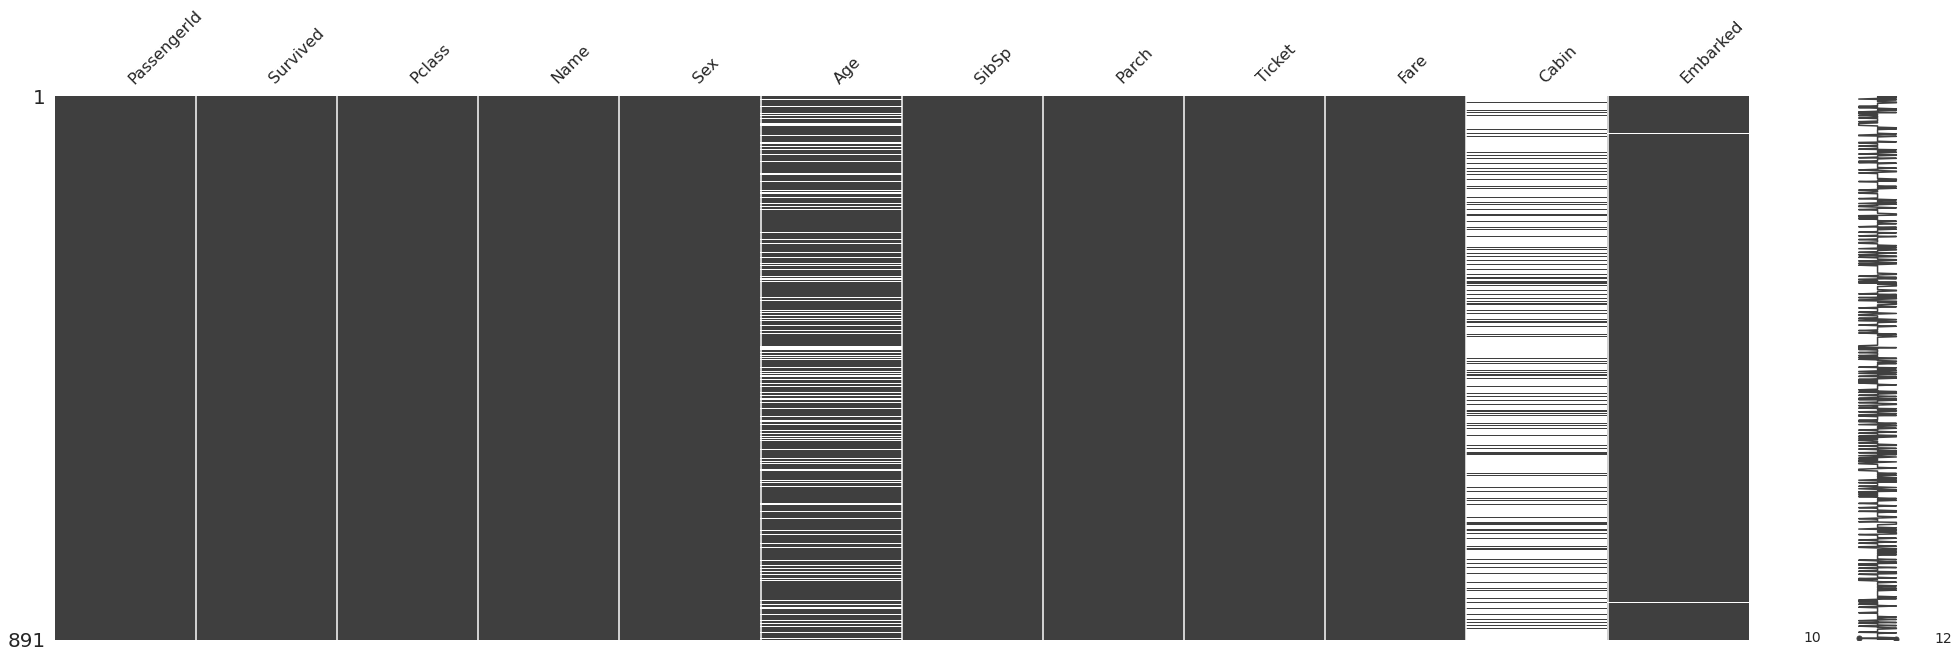

In [19]:
# view missing values in training set

msno.matrix(train_df, figsize = (30,10))

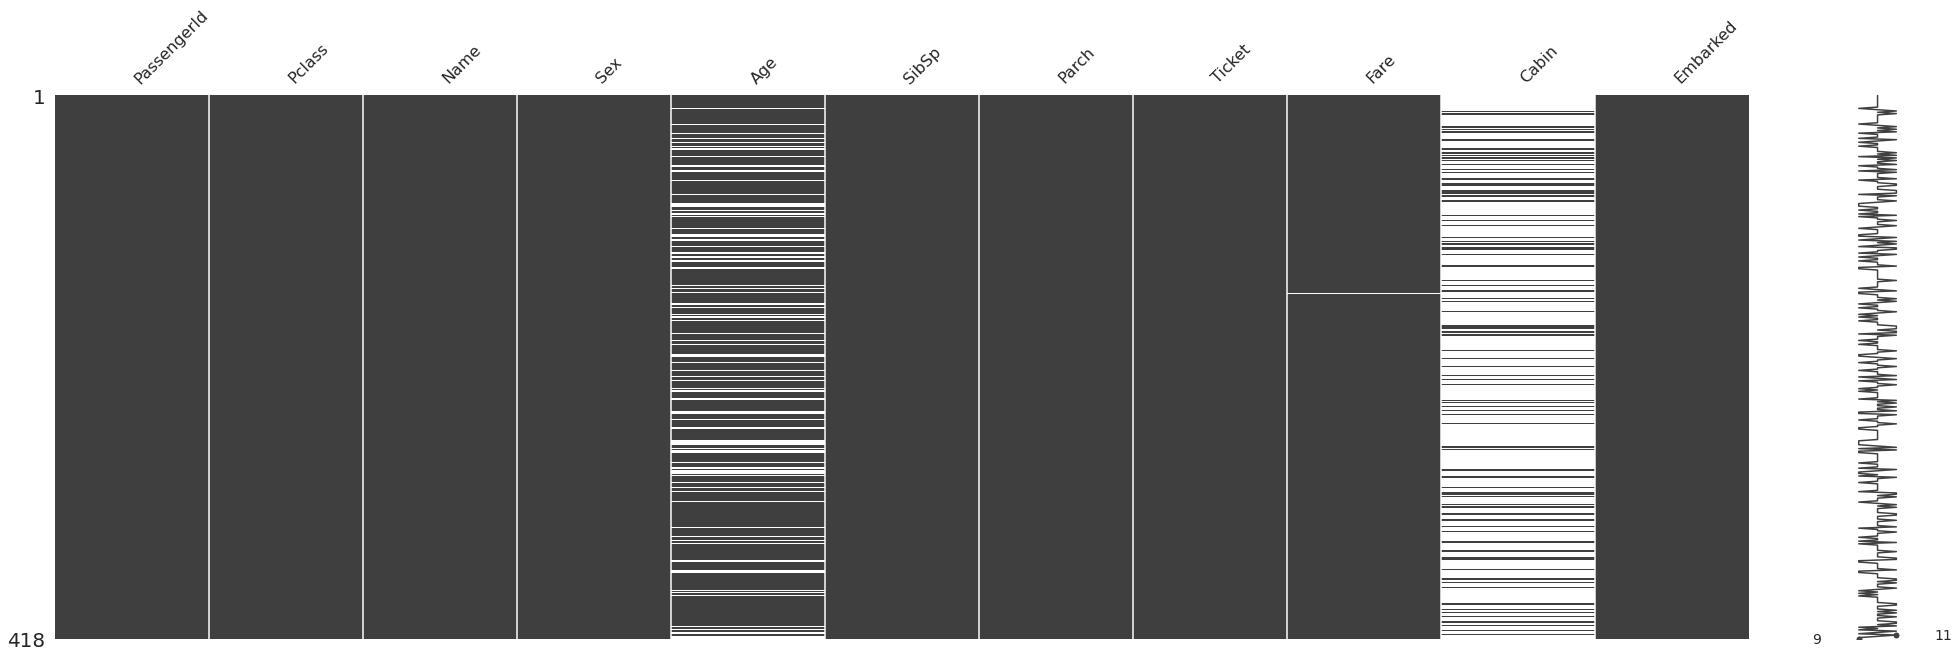

In [20]:
# view missing values in test set

msno.matrix(test_df, figsize = (30,10))

### **5.2 Explore passenger variables**

#### **5.2.1 Survived**  

In [21]:
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Here 0 stands for not survived and 1 stands for survived.

So, 549 people survived and 342 people did not survive.

Let's visualize it by plotting.

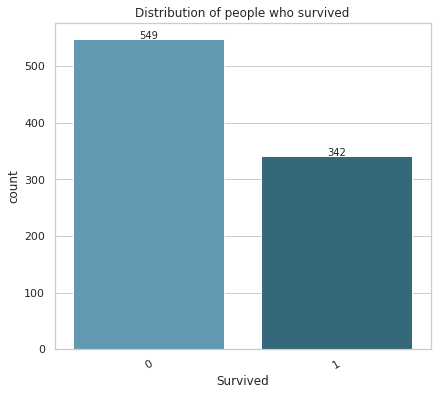

In [22]:
fig, ax = plt.subplots(figsize=(6,6))
graph = sns.countplot(ax=ax,x=train_df['Survived'], data = train_df, palette = 'PuBuGn_d')
graph.set_title('Distribution of people who survived', fontsize = 12)
graph.set_xticklabels(graph.get_xticklabels(),rotation=30)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

Now females have higher probability of survival than males.

Let' check it

In [23]:
train_df.groupby('Survived')['Sex'].value_counts()

Survived  Sex   
0         male      468
          female     81
1         female    233
          male      109
Name: Sex, dtype: int64

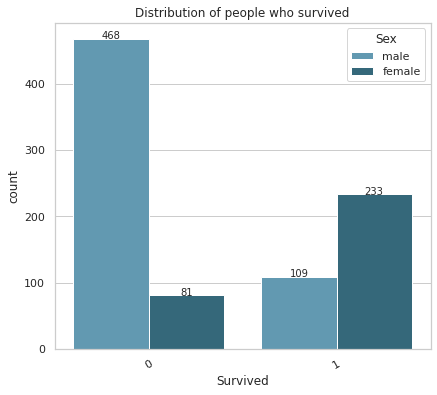

In [24]:
fig, ax = plt.subplots(figsize=(6,6))
graph = sns.countplot(ax=ax,x=train_df['Survived'], data = train_df, hue='Sex', palette = 'PuBuGn_d')
graph.set_title('Distribution of people who survived', fontsize = 12)
graph.set_xticklabels(graph.get_xticklabels(),rotation=30)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

Let's check the percentage of survival for males and females separately.

In [25]:
females = train_df[train_df['Sex'] == 'female']
females.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [26]:
females['Survived'].value_counts()/len(females)

1    0.742038
0    0.257962
Name: Survived, dtype: float64

In [27]:
males = train_df[train_df['Sex'] == 'male']
males.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [28]:
males['Survived'].value_counts()/len(males)

0    0.811092
1    0.188908
Name: Survived, dtype: float64

As expected females have higher probability of survival (value 1) 74.20% than males 18.89%.

Let's visualize it.

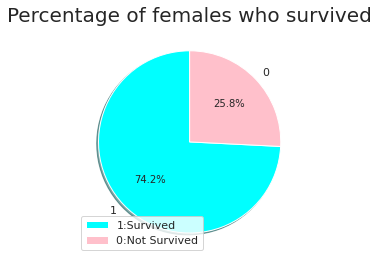

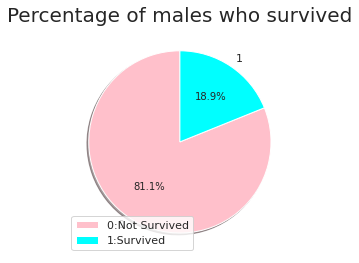

In [29]:
# create the first of two pie-charts and set current axis
plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)   # (rows, columns, panel number)
labels1 = females['Survived'].value_counts().index
size1 = females['Survived'].value_counts()
colors1=['cyan','pink']
plt.pie(size1, labels = labels1, colors = colors1, shadow = True, autopct='%1.1f%%',startangle = 90)
plt.title('Percentage of females who survived', fontsize = 20)
plt.legend(['1:Survived', '0:Not Survived'], loc=0)
plt.show()

# create the second of two pie-charts and set current axis
plt.figure(figsize=(8,6))
plt.subplot(1, 2, 2)   # (rows, columns, panel number)
labels2 = males['Survived'].value_counts().index
size2 = males['Survived'].value_counts()
colors2=['pink','cyan']
plt.pie(size2, labels = labels2, colors = colors2, shadow = True, autopct='%1.1f%%',startangle = 90)
plt.title('Percentage of males who survived', fontsize = 20)
plt.legend(['0:Not Survived','1:Survived'])
plt.show()

#### **5.2.2 Sex** 

In [30]:
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

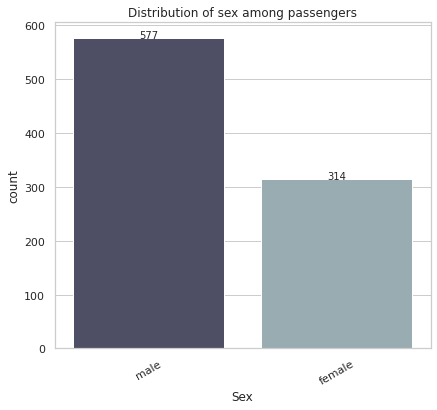

In [31]:
fig, ax = plt.subplots(figsize=(6,6))
graph = sns.countplot(ax=ax,x=train_df['Sex'], data=train_df, palette = 'bone')
graph.set_title('Distribution of sex among passengers', fontsize = 12)
graph.set_xticklabels(graph.get_xticklabels(),rotation=30)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

In [32]:
train_df['Sex'].value_counts()/len(train_df)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

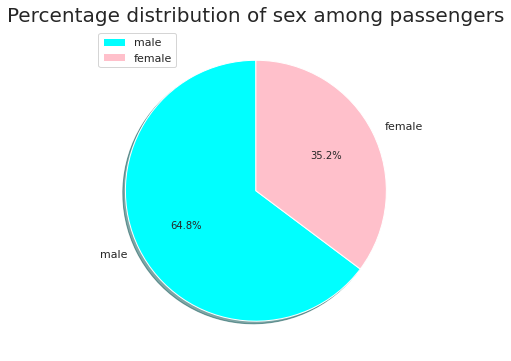

In [33]:
plt.figure(figsize=(8,6))
labels = train_df['Sex'].value_counts().index
size = train_df['Sex'].value_counts()
colors=['cyan','pink']
plt.pie(size, labels = labels, shadow = True, colors=colors, autopct='%1.1f%%',startangle = 90)
plt.title('Percentage distribution of sex among passengers', fontsize = 20)
plt.legend()
plt.show()

#### **5.2.3 Pclass** 

In [34]:
train_df.groupby('Pclass')['Sex'].value_counts()

Pclass  Sex   
1       male      122
        female     94
2       male      108
        female     76
3       male      347
        female    144
Name: Sex, dtype: int64

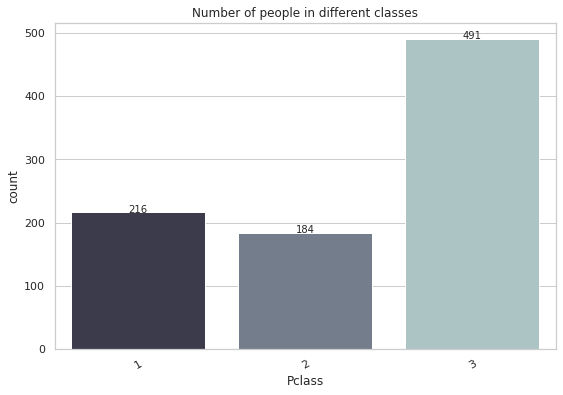

In [35]:
fig, ax = plt.subplots(figsize=(8,6))
graph = sns.countplot(ax=ax,x=train_df['Pclass'], data=train_df, palette = 'bone')
graph.set_title('Number of people in different classes', fontsize = 12)
graph.set_xticklabels(graph.get_xticklabels(),rotation=30)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

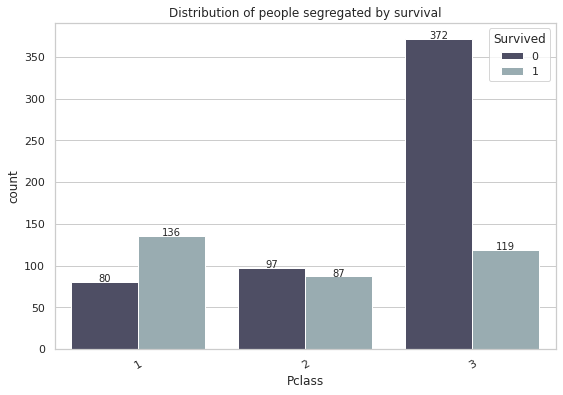

In [36]:
fig, ax = plt.subplots(figsize=(8,6))
graph = sns.countplot(ax=ax,x=train_df['Pclass'], data=train_df, hue='Survived', palette = 'bone')
graph.set_title('Distribution of people segregated by survival', fontsize = 12)
graph.set_xticklabels(graph.get_xticklabels(),rotation=30)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

Here 0 stands for not survived and 1 stands for survived.

So, we can see that Pclass plays a major role in survival.

Majority of people survived in Pclass 1 while a large number of people do not survive in Pclass 3.

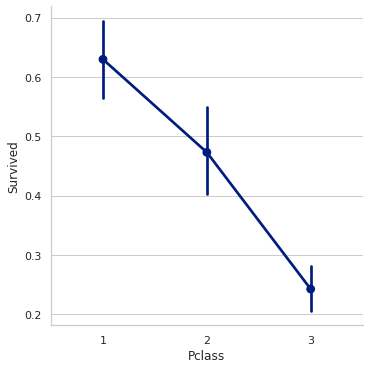

In [37]:
# percentage of survivors per class
sns.factorplot('Pclass', 'Survived', data = train_df)

#### **5.2.4 Embarked** 

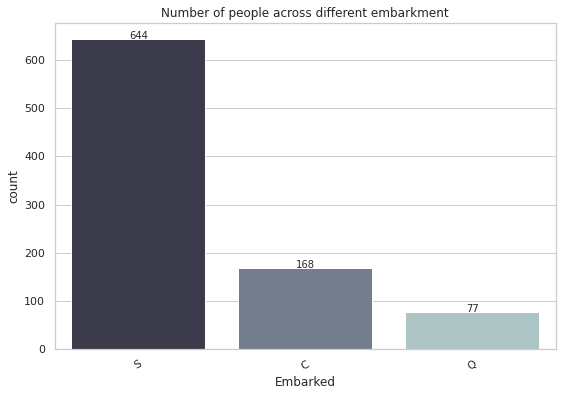

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
graph = sns.countplot(ax=ax,x=train_df['Embarked'], data=train_df, palette = 'bone')
graph.set_title('Number of people across different embarkment', fontsize = 12)
graph.set_xticklabels(graph.get_xticklabels(),rotation=30)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

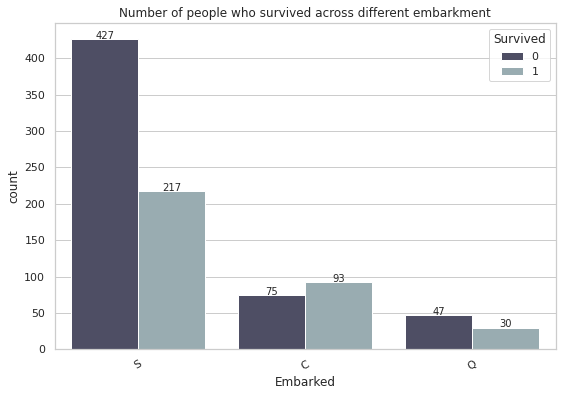

In [39]:
fig, ax = plt.subplots(figsize=(8,6))
graph = sns.countplot(ax=ax,x=train_df['Embarked'], data=train_df, hue='Survived', palette = 'bone')
graph.set_title('Number of people who survived across different embarkment', fontsize = 12)
graph.set_xticklabels(graph.get_xticklabels(),rotation=30)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

We can see that port of embarkment plays a major role in survival probability.

#### **5.2.5 Age** 

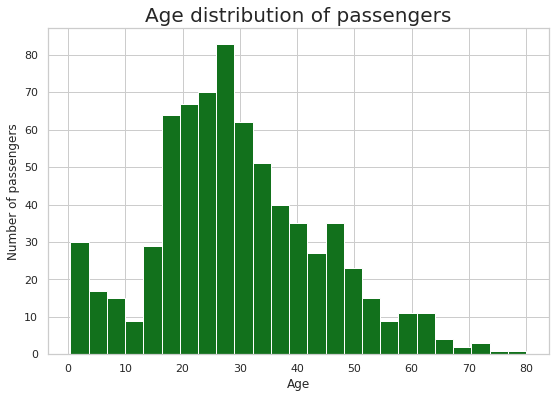

In [40]:
x = train_df['Age']
plt.figure(figsize=(8,6))
plt.hist(x, bins=25, color='g')
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.title('Age distribution of passengers', fontsize = 20)
plt.show()

We can see that majority of passengers are aged between 20 and 40.

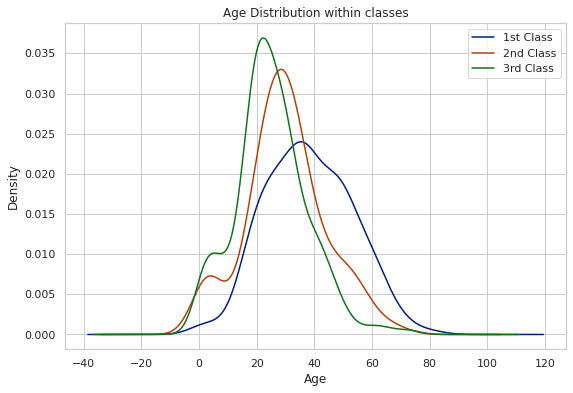

In [41]:
plt.figure(figsize=(8,6))
train_df.Age[train_df.Pclass == 1].plot(kind='kde')    
train_df.Age[train_df.Pclass == 2].plot(kind='kde')
train_df.Age[train_df.Pclass == 3].plot(kind='kde')
 # plots an axis lable
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') ;

### **5.3 Visualizations about training set** 

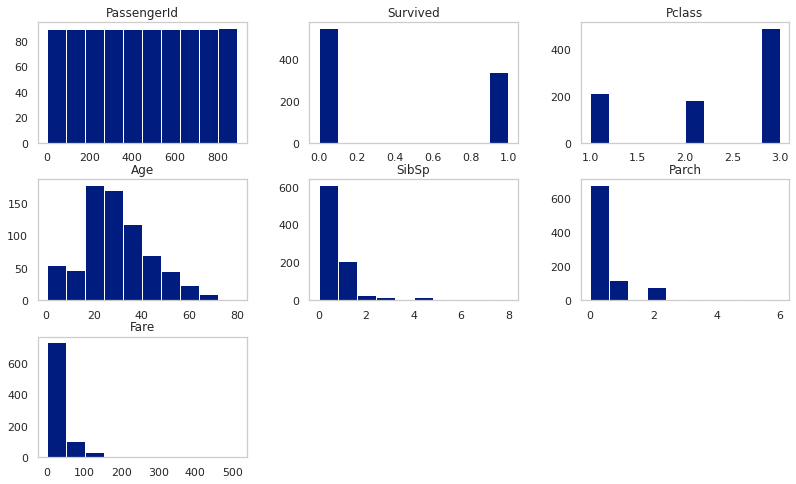

In [42]:
train_df.hist(bins=10,figsize=(12,8),grid=False);

We can see that `Age` and `Fare` are measured on very different scaling. So we need to do feature scaling before predictions.

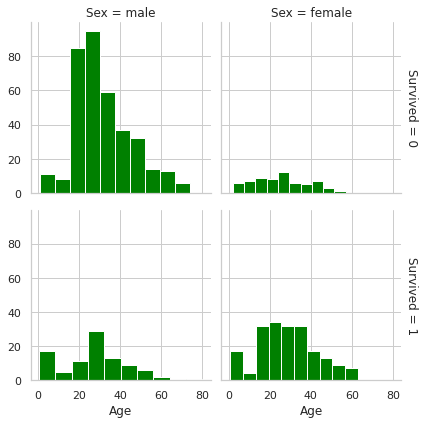

In [43]:
g = sns.FacetGrid(train_df, col="Sex", row="Survived", margin_titles=True)
g.map(plt.hist, "Age", color="green");

### **5.4 Correlation heatmap** 

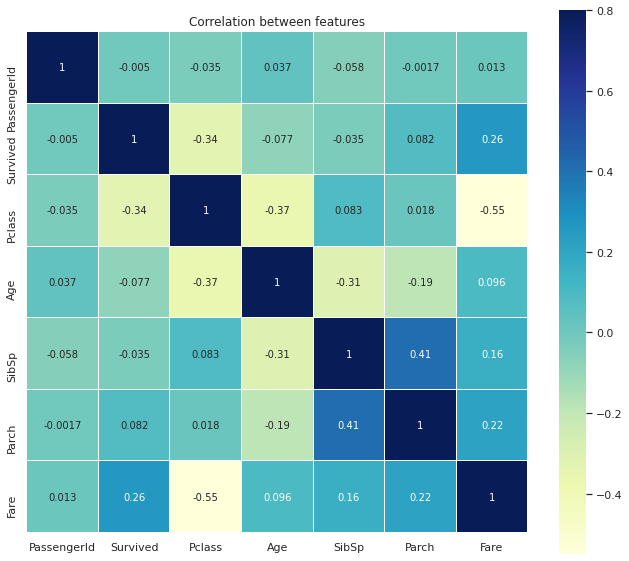

In [44]:
corr = train_df.corr()#["Survived"]
plt.figure(figsize=(10, 10))
sns.heatmap(corr, vmax=.8, linewidths=0.01, square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

In [45]:
#correlation of features with target variable
train_df.corr()["Survived"]

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

So, `Pclass` has got highest negative correlation with `Survived` and `Fare` has got highest positive correlation with `Survived`.

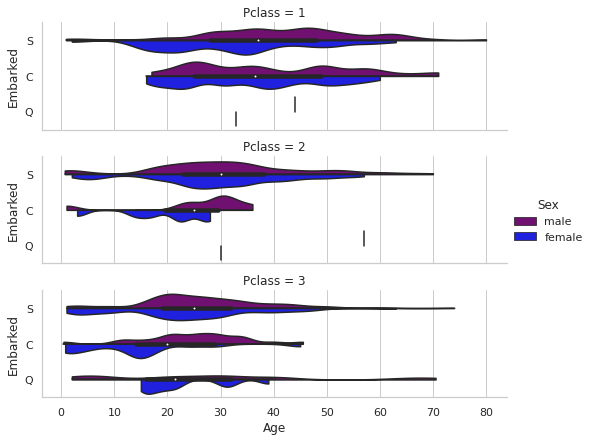

In [46]:
g = sns.factorplot(x="Age", y="Embarked",
                    hue="Sex", row="Pclass",
                    data=train_df[train_df.Embarked.notnull()],
                    orient="h", size=2, aspect=3.5, 
                   palette={'male':"purple", 'female':"blue"},
                    kind="violin", split=True, cut=0, bw=.2);

## **6. Data Preprocessing** 


### **6.1 Missing values imputation** 



It is important to fill missing values, because some machine learning algorithms can't accept them eg SVM.


But filling missing values with mean/median/mode is also a prediction which may not be 100% accurate, instead we can use models like Decision Trees and Random Forest which handle missing values very well.

#### **Embarked Column**

In [47]:
#Lets check which rows have null Embarked column
train_df[train_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


**PassengerId** **62** and **830** have missing embarked values. Both have **Passenger class 1** and **fare $80**.


Now, lets plot a graph to visualize and try to guess from where they embarked.

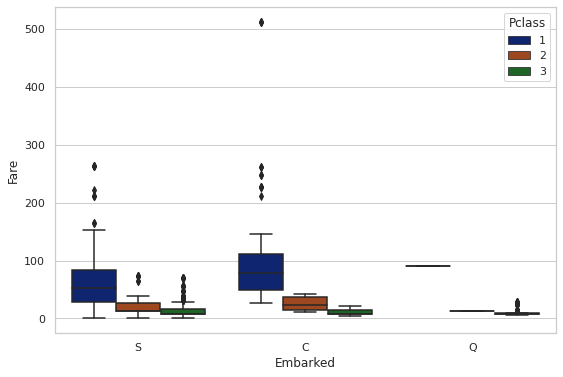

In [48]:
plt.figure(figsize=(8,6))
sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=train_df)
plt.show()

We can see that for 1st class median line is coming around fare $80 for embarked value 'C'. So we can replace NA values in Embarked column with 'C'.

In [49]:
train_df["Embarked"] = train_df["Embarked"].fillna('C')

In [50]:
#there is an empty fare column in test set
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


#### **Fare Column**

In [51]:
test_df[test_df['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [52]:
#we can replace missing value in fare by taking median of all fares of those passengers 
#who share 3rd Passenger class and Embarked from 'S' 
def fill_missing_fare(df):
    median_fare=df[(df['Pclass'] == 3) & (df['Embarked'] == 'S')]['Fare'].median()
#'S'
       #print(median_fare)
    df["Fare"] = df["Fare"].fillna(median_fare)
    return df

test_df=fill_missing_fare(test_df)

## **7. Feature Engineering** 


### **Deck**

-  Where exactly were passenger on the ship?

In [53]:
train_df["Deck"]=train_df.Cabin.str[0]
test_df["Deck"]=test_df.Cabin.str[0]
train_df["Deck"].unique() # 0 is for null values

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

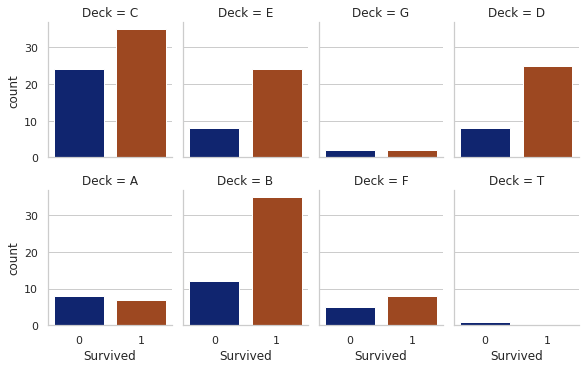

In [54]:
g = sns.factorplot("Survived", col="Deck", col_wrap=4,
                    data=train_df[train_df.Deck.notnull()],
                    kind="count", size=2.5, aspect=.8);

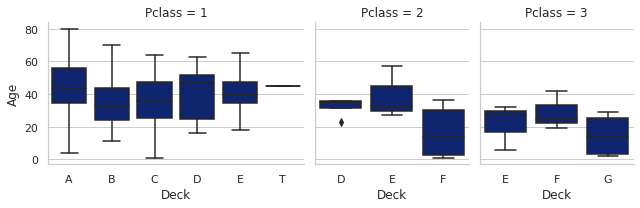

In [55]:
train_df = train_df.assign(Deck=train_df.Deck.astype(object)).sort_values("Deck")
g = sns.FacetGrid(train_df, col="Pclass", sharex=False,
                  gridspec_kws={"width_ratios": [5, 3, 3]})
g.map(sns.boxplot, "Deck", "Age");

In [56]:
train_df.Deck.fillna('Z', inplace=True)
test_df.Deck.fillna('Z', inplace=True)
train_df["Deck"].unique() # Z is for null values

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Z'], dtype=object)

How Big is your family?

In [57]:
# Create a family size variable including the passenger themselves
train_df["FamilySize"] = train_df["SibSp"] + train_df["Parch"]+1
test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"]+1
print(train_df["FamilySize"].value_counts())

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64


In [58]:
# Discretize family size
train_df.loc[train_df["FamilySize"] == 1, "FsizeD"] = 'singleton'
train_df.loc[(train_df["FamilySize"] > 1)  &  (train_df["FamilySize"] < 5) , "FsizeD"] = 'small'
train_df.loc[train_df["FamilySize"] >4, "FsizeD"] = 'large'

test_df.loc[test_df["FamilySize"] == 1, "FsizeD"] = 'singleton'
test_df.loc[(test_df["FamilySize"] >1) & (test_df["FamilySize"] <5) , "FsizeD"] = 'small'
test_df.loc[test_df["FamilySize"] >4, "FsizeD"] = 'large'


In [59]:
print(train_df["FsizeD"].unique())
print(train_df["FsizeD"].value_counts())

['singleton' 'small' 'large']
singleton    537
small        292
large         62
Name: FsizeD, dtype: int64


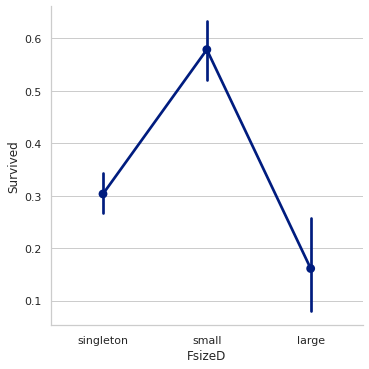

In [60]:
sns.factorplot(x="FsizeD", y="Survived", data=train_df);

### **Do you have longer names?**

In [61]:
#Create feature for length of name 
# The apply method generates a new series

train_df["NameLength"] = train_df["Name"].apply(lambda x: len(x))
test_df["NameLength"] = test_df["Name"].apply(lambda x: len(x))
bins = [0, 20, 40, 57, 85]
group_names = ['short', 'okay', 'good', 'long']
train_df['NlengthD'] = pd.cut(train_df['NameLength'], bins, labels=group_names)
test_df['NlengthD'] = pd.cut(test_df['NameLength'], bins, labels=group_names)


['okay', 'short', 'good', 'long']
Categories (4, object): ['short' < 'okay' < 'good' < 'long']


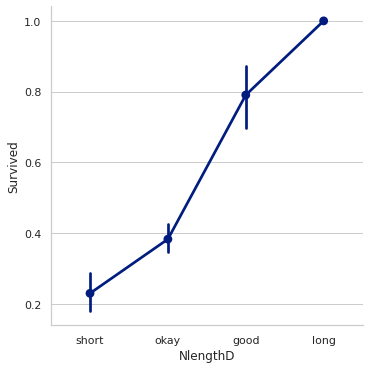

In [62]:
sns.factorplot(x="NlengthD", y="Survived", data=train_df)
print(train_df["NlengthD"].unique())

### **What's in the name?**

In [63]:
import re

#A function to get the title from a name.
def get_title(name):
    """Use a regular expression to search for a title.  
       Titles always consist of capital and lowercase letters, and end with a period"""
    title_search = re.search(' ([A-Za-z]+)\.', name)
    #If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [64]:
#Get all the titles and print how often each one occurs.
titles = train_df["Name"].apply(get_title)
print(pd.value_counts(titles))


Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Sir           1
Countess      1
Capt          1
Ms            1
Lady          1
Jonkheer      1
Mme           1
Don           1
Name: Name, dtype: int64


In [65]:
#Add in the title column.
train_df["Title"] = titles

In [66]:
# Titles with very low cell counts to be combined to "rare" level
rare_title = ['Dona', 'Lady', 'Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']


In [67]:
# Also reassign mlle, ms, and mme accordingly
train_df.loc[train_df["Title"] == "Mlle", "Title"] = 'Miss'
train_df.loc[train_df["Title"] == "Ms", "Title"] = 'Miss'
train_df.loc[train_df["Title"] == "Mme", "Title"] = 'Mrs'
train_df.loc[train_df["Title"] == "Dona", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Lady", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Countess", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Capt", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Col", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Don", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Major", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Rev", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Sir", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Jonkheer", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Dr", "Title"] = 'Rare Title'


### **Do the same with test set**

In [68]:
titles = test_df["Name"].apply(get_title)
print(pd.value_counts(titles))

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Name, dtype: int64


In [69]:
#Add in the title column.
test_df["Title"] = titles


In [70]:
# Titles with very low cell counts to be combined to "rare" level
rare_title = ['Dona', 'Lady', 'Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

In [71]:
# Also reassign mlle, ms, and mme accordingly
test_df.loc[test_df["Title"] == "Mlle", "Title"] = 'Miss'
test_df.loc[test_df["Title"] == "Ms", "Title"] = 'Miss'
test_df.loc[test_df["Title"] == "Mme", "Title"] = 'Mrs'
test_df.loc[test_df["Title"] == "Dona", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Lady", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Countess", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Capt", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Col", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Don", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Major", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Rev", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Sir", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Jonkheer", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Dr", "Title"] = 'Rare Title'


In [72]:
test_df["Title"].value_counts()

Mr            240
Miss           79
Mrs            72
Master         21
Rare Title      6
Name: Title, dtype: int64

### **Ticket column**

In [73]:
train_df["Ticket"].tail()

884    SOTON/OQ 392076
885             382652
886             211536
888         W./C. 6607
890             370376
Name: Ticket, dtype: object

In [74]:
train_df["TicketNumber"] = train_df["Ticket"].str.extract('(\d{2,})', expand=True)
train_df["TicketNumber"] = train_df["TicketNumber"].apply(pd.to_numeric)

In [75]:
test_df["TicketNumber"] = test_df["Ticket"].str.extract('(\d{2,})', expand=True)
test_df["TicketNumber"] = test_df["TicketNumber"].apply(pd.to_numeric)

In [76]:
#some rows in ticket column dont have numeric value so we got NaN there
train_df[train_df["TicketNumber"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,FamilySize,FsizeD,NameLength,NlengthD,Title,TicketNumber
772,773,0,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.5,E77,S,E,1,singleton,17,short,Mrs,NaN
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,Z,1,singleton,19,short,Mr,NaN
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,Z,1,singleton,28,okay,Mr,NaN
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,Z,1,singleton,31,okay,Mr,NaN
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,Z,1,singleton,19,short,Mr,NaN
841,842,0,2,"Mudd, Mr. Thomas Charles",male,16.0,0,0,S.O./P.P. 3,10.5,NaN,S,Z,1,singleton,24,okay,Mr,NaN


In [77]:
train_df.TicketNumber.fillna(train_df["TicketNumber"].median(), inplace=True)
test_df.TicketNumber.fillna(test_df["TicketNumber"].median(), inplace=True)

## **8. Categorical Encoding** 

In [78]:
labelenc=LabelEncoder()

cat_vars=['Embarked','Sex',"Title","FsizeD","NlengthD",'Deck']
for col in cat_vars:
    train_df[col]=labelenc.fit_transform(train_df[col])
    test_df[col]=labelenc.fit_transform(test_df[col])

In [79]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,FamilySize,FsizeD,NameLength,NlengthD,Title,TicketNumber
475,476,0,1,"Clifford, Mr. George Quincy",1,NaN,0,0,110465,52.0000,A14,2,0,1,1,27,2,2,110465.0
174,175,0,1,"Smith, Mr. James Clinch",1,56.0,0,0,17764,30.6958,A7,0,0,1,1,23,2,2,17764.0
209,210,1,1,"Blank, Mr. Henry",1,40.0,0,0,112277,31.0000,A31,0,0,1,1,16,3,2,112277.0
445,446,1,1,"Dodge, Master. Washington",1,4.0,0,2,33638,81.8583,A34,2,0,3,2,25,2,0,33638.0
647,648,1,1,"Simonius-Blumer, Col. Oberst Alfons",1,56.0,0,0,13213,35.5000,A26,0,0,1,1,35,2,4,13213.0


### **Age Column**

Age seems to be promising feature. So it doesnt make sense to simply fill null values out with median/mean/mode.

We will use Random Forest algorithm to predict ages.

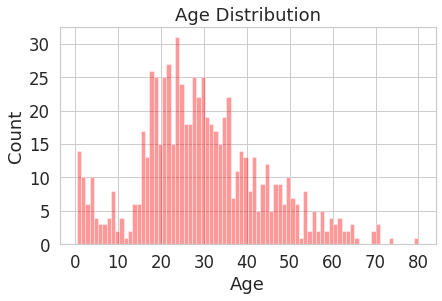

In [80]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(train_df["Age"].dropna(),
                 bins=80,
                 kde=False,
                 color="red")
    plt.title("Age Distribution")
    plt.ylabel("Count");

In [81]:
from sklearn.ensemble import RandomForestRegressor
#predicting missing values in age using Random Forest
def fill_missing_age(df):
    
    #Feature set
    age_df = df[['Age','Embarked','Fare', 'Parch', 'SibSp',
                 'TicketNumber', 'Title','Pclass','FamilySize',
                 'FsizeD','NameLength',"NlengthD",'Deck']]
    # Split sets into train and test
    train  = age_df.loc[ (df.Age.notnull()) ]# known Age values
    test = age_df.loc[ (df.Age.isnull()) ]# null Ages
    
    # All age values are stored in a target array
    y = train.values[:, 0]
    
    # All the other values are stored in the feature array
    X = train.values[:, 1::]
    
    # Create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedAges = rtr.predict(test.values[:, 1::])
    
    # Assign those predictions to the full data set
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
    return df

In [82]:
train_df=fill_missing_age(train_df)
test_df=fill_missing_age(test_df)

## **9. Feature Scaling** 


We can see that Age, Fare are measured on different scales, so we need to do Feature Scaling first before we proceed with making predictions with **stacked classifier**.

In [83]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(train_df[['Age', 'Fare']])
train_df[['Age', 'Fare']] = std_scale.transform(train_df[['Age', 'Fare']])


std_scale = preprocessing.StandardScaler().fit(test_df[['Age', 'Fare']])
test_df[['Age', 'Fare']] = std_scale.transform(test_df[['Age', 'Fare']])

### **Correlation of features with target**

In [84]:
train_df.corr()["Survived"]

PassengerId    -0.005007
Survived        1.000000
Pclass         -0.338481
Sex            -0.543351
Age            -0.078653
SibSp          -0.035322
Parch           0.081629
Fare            0.257307
Embarked       -0.174199
Deck           -0.301116
FamilySize      0.016639
FsizeD          0.283810
NameLength      0.332350
NlengthD       -0.312234
Title          -0.071174
TicketNumber   -0.096161
Name: Survived, dtype: float64

## **10. Declare feature vector and target label** 

In [85]:
# Declare feature vector and target variable
X_train = train_df.drop(labels = ['Survived'],axis = 1)
y_train = train_df['Survived']
X_test = test_df


## **11. Individual Classifiers** 


For the purpose of illustration, we will train a **Support Vector Classifier (SVC)**, **Multi-layer Perceptron (MLP) classifier**, **Nu-Support Vector classifier (NuSVC)** and a **Random Forest (RF) classifier** — classifiers available in Scikit-learn. 


In [86]:
# Initializing Support Vector classifier
clf_svc = SVC(C = 50, degree = 1, gamma = "auto", kernel = "rbf", probability = True)

# Initializing Multi-layer perceptron  classifier
clf_mlp = MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (10,10,10),
                            learning_rate = "constant", max_iter = 2000, random_state = 1000)

# Initialing Nu Support Vector classifier
clf_nusvc = NuSVC(degree = 1, kernel = "rbf", nu = 0.25, probability = True)

# Initializing Random Forest classifier
clf_rfc = RandomForestClassifier(n_estimators = 500, criterion = "gini", max_depth = 10,
                                     max_features = "auto", min_samples_leaf = 0.005,
                                     min_samples_split = 0.005, n_jobs = -1, random_state = 1000)

## **12. Stacked Classifier** 

- To stack the above classifiers, we will use the [StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) from scikit-learn library.


- We can also use the [StackingCVClassifier](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/) from MLXTEND for the same purpose. We can take a look at the [official documentation](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/) since it goes in detail over useful examples of how to implement the StackingCVClassifier.


In [87]:
classifiers = [('svc', clf_svc),
               ('mlp', clf_mlp),                             
               ('nusvc', clf_nusvc),
               ('rfc', clf_rfc)]

In [88]:
clf = StackingClassifier(estimators=classifiers, 
                         final_estimator=LogisticRegression(),
                         stack_method='auto',
                         n_jobs=-1,
                         passthrough=False)

In [89]:
predictors=["Pclass", "Sex", "Age", "Fare", "Embarked","NlengthD",
              "FsizeD", "Title","Deck","NameLength","TicketNumber"]

clf.fit(X_train[predictors],y_train)

StackingClassifier(cv=None,
                   estimators=[('svc',
                                SVC(C=50, break_ties=False, cache_size=200,
                                    class_weight=None, coef0=0.0,
                                    decision_function_shape='ovr', degree=1,
                                    gamma='auto', kernel='rbf', max_iter=-1,
                                    probability=True, random_state=None,
                                    shrinking=True, tol=0.001, verbose=False)),
                               ('mlp',
                                MLPClassifier(activation='relu', alpha=0.1,
                                              batch_size='auto', beta_1=0.9,
                                              beta...
                                                       random_state=1000,
                                                       verbose=0,
                                                       warm_start=False))],
                   fin

In [90]:
test_predictions=clf.predict(X_test[predictors])


In [91]:
test_predictions=test_predictions.astype(int)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": test_predictions
    })

submission.to_csv("titanic_submission.csv", index=False)